In [1]:
%matplotlib inline
%cd /home/vadmas/dev/projects/active/alpha_ais

/home/vadmas/dev/projects/active/alpha_ais


In [2]:
from IPython.display import set_matplotlib_formats
import numpy as np
import matplotlib
import janitor
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
set_matplotlib_formats('retina')
pd.set_option('mode.chained_assignment', None)
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
from src.paths import alpha_average
from src.ais import Gaussian1D, Student1D, find_average_batch, run_ais, run_alpha_average_loops
from src.utils import pmap
from itertools import product

In [3]:
## global parameters

In [4]:
beta_vec = np.linspace(0, 1, 11)
proposal = Student1D(2, -4.0, 3)
target   = Student1D(2, 4.0, 1)
no_samples = 50000

In [5]:
# comment out unneeded q
q_vec = [
    0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    1. 
]

In [7]:
def plot_ridge(data, alpha_vec, left=-20, right=10):
    # truncate samples outside of range, then downsample so each dist
    # has the same number of total samples
    data = (data
         .query("@left < x < @right")
         .groupby(['q','beta'])
         .sample(10000))
    
    
    data['label'] = data.beta.apply(lambda x: r"$\beta=${:.02}".format(x))
    pal = sns.cubehelix_palette(11, rot=-.25, light=.7)
    g = sns.FacetGrid(data, 
                      row="label", 
                      hue="label", 
                      sharey='row',
                      col='q',
                      aspect=15,
                      height=.5,
                      palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot,
          "x",
          bw_adjust=.5,
          clip=(left, right),
          fill=True, 
          alpha=1,
          linewidth=1.5)

    g.map(sns.kdeplot,
          "x",
          clip=(left, right),
          color="w",
          lw=2,
          bw_adjust=.5)
    
    g.map(plt.axhline, y=0, lw=2, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, "x")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    cols = [r"$q = {:.02}$".format(float(alpha)) for alpha in alpha_vec]

    for ax, col in zip(g.axes[0], cols):
        ax.set_title(col, fontsize=26)
    
    g.despine(bottom=True, left=True)
    return g


def trace_plot(chain):
    # uses first column
    chain = chain.iloc[:, 0]
    
    # to check if the chain mixed
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.plot(np.arange(chain.shape[0]),chain)
    plt.title('Trace Plot for $\\mu$')

    plt.subplot(122)
    plt.hist(chain,orientation='horizontal',bins=30)
    plt.title('Histogram for $\\mu$')

    plt.tight_layout()
    plt.show()
    
    
def run_hmc(beta, q):
    alpha = (2*q) - 1
    samples = alpha_average(proposal, target, beta, alpha).sample(no_samples)
    df = pd.Series(samples).to_frame()
    df['beta'] = beta
    df['q'] =  q
    return df

In [8]:
# run all chains in parallel
# will work with however many cores you have available
res = pd.concat(pmap(lambda x: run_hmc(x[0], x[1]),
                     product(beta_vec, q_vec),
                     notebook=True),
                axis=0).rename_column(0,'x')

In [22]:
res

,x,beta,q
0,-4.296864,0.0,-1.0
1,-4.130236,0.0,-1.0
2,-26.678789,0.0,-1.0
3,-0.477381,0.0,-1.0
4,-4.516029,0.0,-1.0
...,...,...,...
49995,8.366140,1.0,1.0
49996,6.943099,1.0,1.0
49997,6.558656,1.0,1.0
49998,4.539927,1.0,1.0


In [12]:
# cache long running chains for later

res.to_pickle("./results/chain_11_15.pkl")
# res = pd.read_pickle("./results/chain_11_11.pkl")

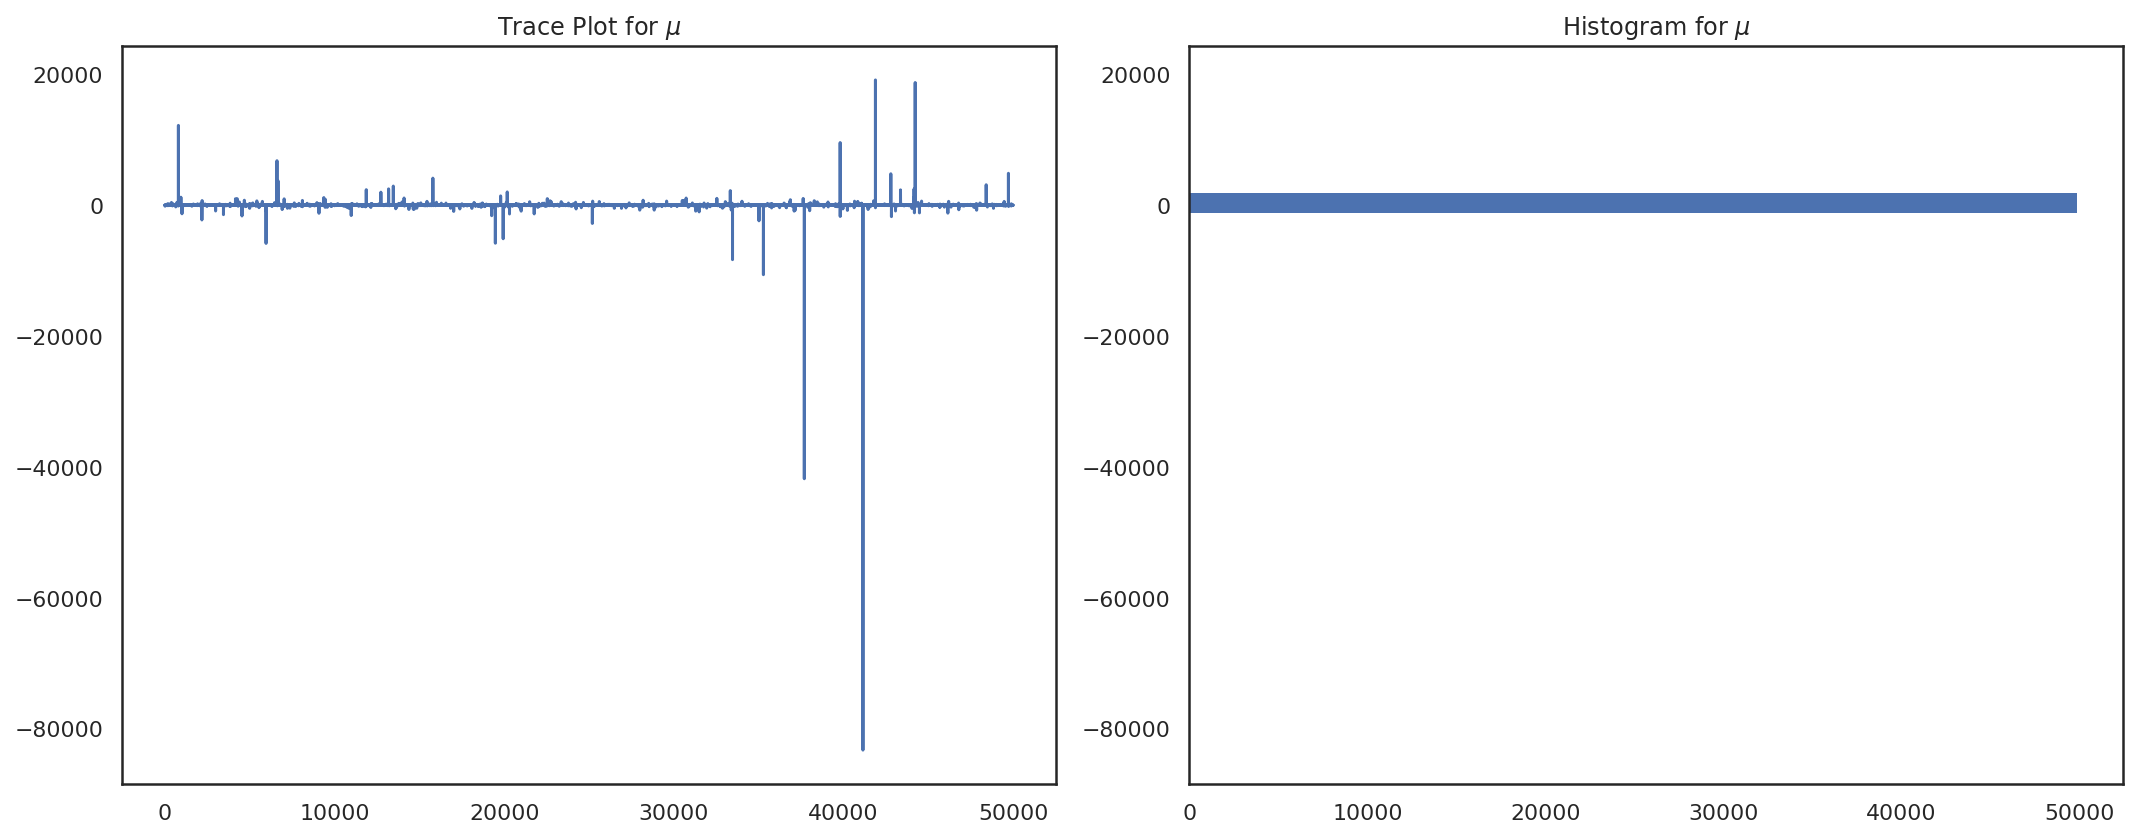

In [13]:
# look at trace plots for any alpha/beta to make sure chain converged (important as soon)
trace_plot(res.query("q == 0 and beta==0")) 

/home/vadmas/miniconda/envs/ml3/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/home/vadmas/miniconda/envs/ml3/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/home/vadmas/miniconda/envs/ml3/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/home/vadmas/miniconda/envs/ml3/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


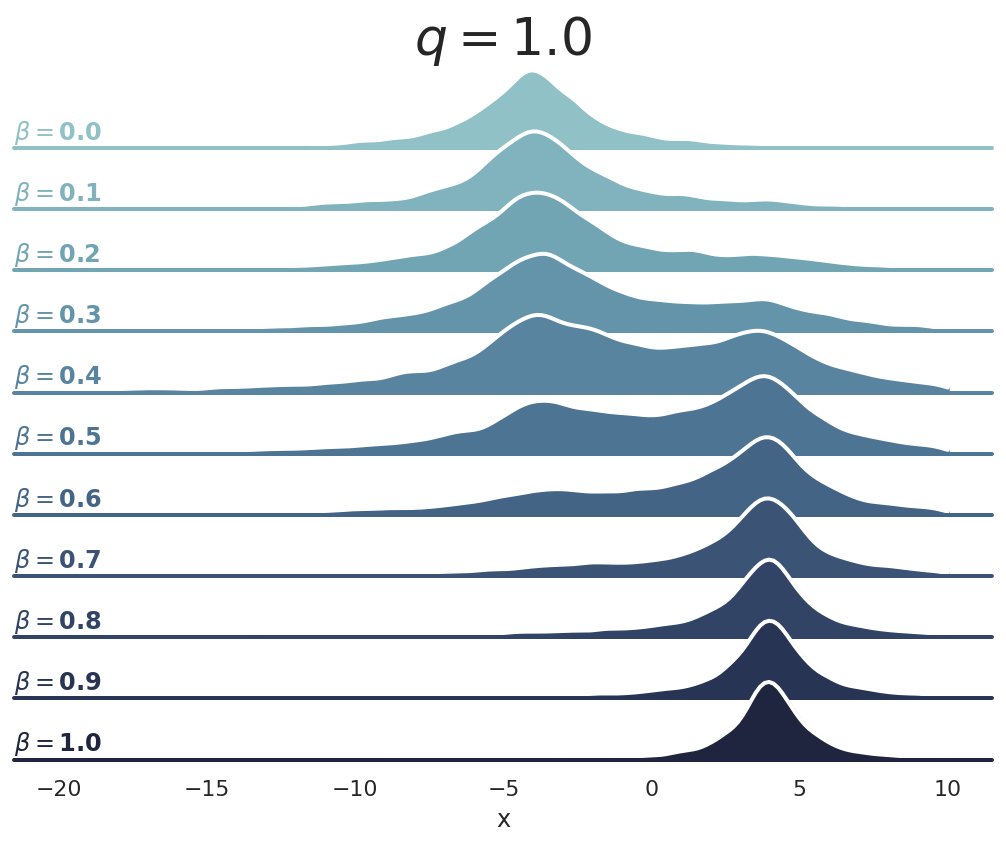

In [14]:
# plot single alpha
test_q = 1
plot_ridge(res[res.q == test_q], [test_q])

/home/vadmas/miniconda/envs/ml3/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/home/vadmas/miniconda/envs/ml3/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/home/vadmas/miniconda/envs/ml3/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/home/vadmas/miniconda/envs/ml3/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


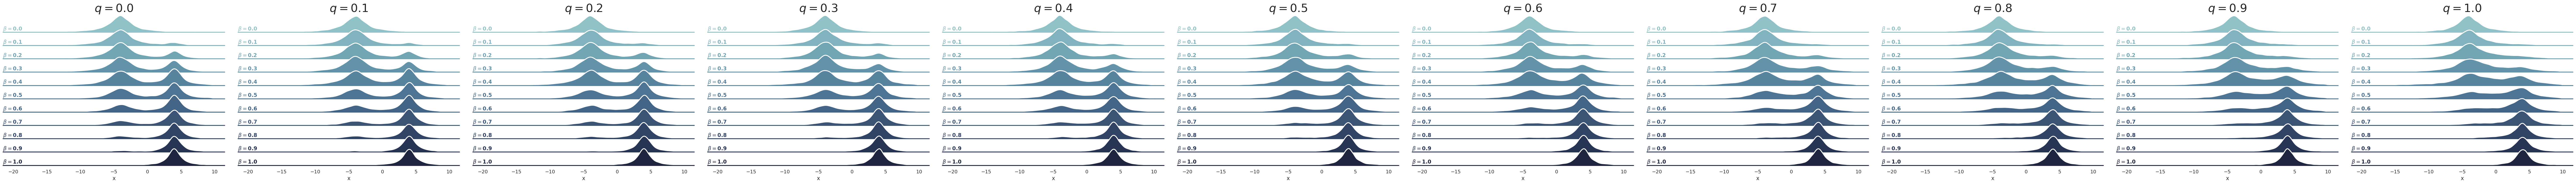

In [15]:
# plot all alphas
plot_ridge(res, q_vec)